In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit
# %matplotlib inline

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
#from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()

from prody import *

import pickle

from scipy.ndimage.filters import gaussian_filter
import matplotlib.tri as tri
from matplotlib.lines import Line2D
import random
random.seed(10)

In [2]:
data_path = Path('/data/cresswellclayec/covid_data/spikeprot1201')
variant_name1 = 'Delta'
variant_name2 = 'Omicron'
variants = [variant_name1, variant_name2]


In [3]:
# load variant dataframes
if 0:
    variant_metadata = pd.read_csv("/data/cresswellclayec/covid_data/variant_surveillance/variant_surveillance.tsv",sep='\t',low_memory=False)
    print(variant_metadata.head())
else:
    input_data_file = 'variant_dfs.pickle' 

    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            variant_metadata_dict = pickle.load(f)
    f.close()

    print(variant_metadata_dict.keys())
    print(variant_metadata_dict[variant_name1].head())
    

dict_keys(['Omicron', 'Delta', 'Epsilon', 'Eta', 'Iota', 'Alpha', 'Beta', 'Zeta', 'Gamma', 'Kappa', 'GH/490R', 'Lambda', 'Mu', 'Theta'])
          Accession ID             Type Clade Pango lineage Pangolin version  \
624    EPI_ISL_8997419  betacoronavirus    GK         AY.43     PLEARN-v1.16   
5017  EPI_ISL_10185319  betacoronavirus    GK         AY.43     PLEARN-v1.16   
5112  EPI_ISL_10209519  betacoronavirus    GK         AY.47     PLEARN-v1.16   
6025  EPI_ISL_11316519  betacoronavirus    GK         AY.54     PLEARN-v1.16   
6036  EPI_ISL_11427619  betacoronavirus    GK        AY.112     PLEARN-v1.16   

                                       AA Substitutions  \
624   (N_D377Y,M_I82T,N_D63G,Spike_D950N,N_R203M,NSP...   
5017  (NSP5_P132H,N_G215C,Spike_T95I,N_D63G,N_R203M,...   
5112  (NSP1_A117V,N_D63G,N_R203M,NSP12_G671S,Spike_V...   
6025  (NS7a_L116F,N_D63G,N_R203M,NSP12_G671S,Spike_G...   
6036  (N_G215C,N_D63G,N_R203M,NSP12_G671S,NS3_S26L,N...   

                           

In [4]:
meta1 = variant_metadata_dict[variant_name1]
meta2 = variant_metadata_dict[variant_name2]
print(len(meta1))
print(len(meta2))

4550038
6679236


In [5]:
# load variant s0 from column-union data file (made after all variants were processed, union of retained cols)
# Something is wrong with general data file.
if 1:
    input_data_file = 'spike_s0_data.pickle' 
    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            s0_dict = pickle.load(f)
    f.close()

    s01 = s0_dict[variant_name1]
    s02  =s0_dict[variant_name2]
    print(s01.shape)
    print(s02.shape)
    
    input_data_file = 'spike_accession_data.pickle' 
    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            accession_dict = pickle.load(f)
    f.close()

    accession1 = accession_dict[variant_name1]
    accession2  =accession_dict[variant_name2]
    print(accession1.shape)
    print(accession2.shape)
    
    input_data_file = 'spike_index_data.pickle' 
    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            index_dict = pickle.load(f)
    f.close()

    s_index1 = index_dict[variant_name1]
    s_index2  =index_dict[variant_name2]
    print(s_index1.shape)
    print(s_index2.shape)
    
    input_data_file = 'spike_ipdb_data.pickle' 
    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            ipdb_dict = pickle.load(f)
    f.close()

    s_ipdb1 = ipdb_dict[variant_name1]
    s_ipdb2 = ipdb_dict[variant_name2]
    print(s_ipdb1)
    print(s_ipdb2)

(882050, 344)
(832483, 344)
(882050,)
(832483,)
(344,)
(344,)
0
0


In [6]:
# data now loaded through pickle files which have info for all variants together
if 0:
    input_data_file = '%s_processed_data.pickle' % variant_name1

    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            pf_dict = pickle.load(f)
    f.close()

    s01 = pf_dict['s0']
    s_ipdb1 = pf_dict['s_ipdb']
    print('%s s0: '% variant_name1, s01.shape)
    s_index1 = pf_dict['s_index']
    cols_removed1 = pf_dict['cols_removed']
    s_ipdb1 = 0

    input_data_file = '%s_processed_data.pickle' % variant_name2

    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            pf_dict = pickle.load(f)
    f.close()

    s02 = pf_dict['s0']
    s_ipdb2 = pf_dict['s_ipdb']
    print('%s s0: '% variant_name2, s02.shape)
    s_index2 = pf_dict['s_index']
    cols_removed2 = pf_dict['cols_removed']
    s_ipdb2 = 0
    print(s_index1, s_index2)
elif 0:
    
    s01 = np.load('%s_processed_s0.npy' %variants[0])
#     accession1 = np.load('%s_processed_accession.npy' %variants[0])
    accession1 = np.load('%s_accession.npy' %variants[0])

    s_ipdb1 = np.load('%s_processed_ipdb.npy' %variants[0])
    s_index1 = np.load('%s_processed_sindex.npy' %variants[0])

    s02 = np.load('%s_processed_s0.npy' %variants[1])
#     accession2 = np.load('%s_processed_accession.npy' %variants[1])
    accession2 = np.load('%s_accession.npy' %variants[1])   

    s_ipdb2 = np.load('%s_processed_ipdb.npy' %variants[1])
    s_index2 = np.load('%s_processed_sindex.npy' %variants[1])
    
# print(cols_removed1, cols_removed2)


4550038
882050
            Accession ID             Type Clade Pango lineage  \
1612262  EPI_ISL_6847706  betacoronavirus    GK        AY.4.6   
442613   EPI_ISL_4893444  betacoronavirus    GK          AY.4   
1240274  EPI_ISL_3579017  betacoronavirus    GK         AY.43   
1375655  EPI_ISL_8112434  betacoronavirus    GK       AY.29.2   
1649615  EPI_ISL_6842222  betacoronavirus    GK         AY.85   

        Pangolin version                                   AA Substitutions  \
1612262     PLEARN-v1.16  (N_G215C,NSP3_A1711V,Spike_T95I,N_D63G,N_R203M...   
442613      PLEARN-v1.16  (N_G215C,NSP3_A1711V,N_D63G,N_R203M,NSP12_G671...   
1240274     PLEARN-v1.16  (N_G215C,N_D63G,N_R203M,NSP12_G671S,Spike_G142...   
1375655      PANGO-v1.16  (N_G215C,Spike_T95I,N_D63G,N_R203M,NSP12_G671S...   
1649615     PLEARN-v1.16  (N_G215C,Spike_T95I,N_D63G,N_R203M,NSP12_G671S...   

                                                   Variant Collection date  \
1612262  VOC Delta GK (B.1.617.2+AY.*) fi

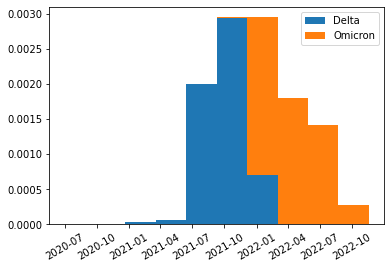

In [7]:
# bin the variant sequences chronologically by accession
n = 10000


print(len(meta1))
print(len(accession1))
# get random sample of accessions
var1_partial_index = random.sample([indx for indx in range(len(accession1))],n)
var2_partial_index = random.sample([indx for indx in range(len(accession2))],n)
# print(accession1[var1_partial_index])

# get sample df
meta1_partial = meta1.iloc[var1_partial_index].copy()
meta2_partial = meta2.iloc[var2_partial_index].copy()
print(meta1_partial.head())
# print(meta2_partial.head())

# print(len(meta1_partial))
# extract dates for variant samples


meta1_partial["Collection date"] = meta1_partial["Collection date"].astype("datetime64")
meta2_partial["Collection date"] = meta2_partial["Collection date"].astype("datetime64")

df = pd.concat([meta1_partial, meta2_partial])[['Collection date', 'Variant']]
df1 = meta1_partial[['Collection date', 'Variant']]
df2 = meta2_partial[['Collection date', 'Variant']]

# df1.groupby([df1["Collection date"].dt.year, df1["Collection date"].dt.month]).count().plot.bar(y='Variant')
# df2.groupby([df2["Collection date"].dt.year, df2["Collection date"].dt.month]).count().plot.bar(y='Variant')

# Create histogram on MEDV column (target column)
fig, ax = plt.subplots(nrows=1, ncols=1)

# Create list of data according to different accessibility index
var1 = 'VOC Omicron GRA (B.1.1.529+BA.*) first detected in Botswana/Hong Kong/South Africa'
var2 = 'VOC Delta GK (B.1.617.2+AY.*) first detected in India'

x1 = list(df[df['Variant'] == var1]['Collection date'])
x2 = list(df[df['Variant'] == var2]['Collection date'])
names = [variant_name1, variant_name2]

plt.hist([x2,x1], label=names, stacked=True, density=True)
plt.xticks(rotation=30)
# Set the legend and labels
#
plt.legend()


In [8]:
print('gp 1 metadata len', len(meta1_partial))
print('gp 2 metadata len', len(meta2_partial))


# sample n sequences from each alignment


print(s02.shape)

# get all possible samplings from families for consistent grouping 
s01_partial_index = random.sample([indx for indx in range(len(s01))],n)
s02_partial_index = random.sample([indx for indx in range(len(s02))],n)

# combine variant MSAs to encode.
s0_full = np.concatenate((s01[s01_partial_index], s02[s02_partial_index]), axis=0)
s0_all_seqs = np.concatenate((s01, s02), axis=0)
print('number of %s and %s sequences: '%(variant_name1, variant_name2),len(s0_all_seqs))
# s0_full = s01

onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
print('Omicron s0: ',s0_full.shape,'\n',s0_full)
onehot_encoder.fit(s0_full)
s = onehot_encoder.transform(s0_full)
print('s: ',s.shape,'\n',s)

gp 1 metadata len 10000
gp 2 metadata len 10000
(832483, 344)
number of Delta and Omicron sequences:  1714533
Omicron s0:  (20000, 344) 
 [[10  4 17 ...  2  2  8]
 [10  4 17 ...  2  2  8]
 [12 11  6 ...  2  2  8]
 ...
 [10  4 17 ...  2  2  8]
 [10  4 17 ...  2  2  8]
 [10  4 17 ...  2  2  8]]
s:  (20000, 651) 
 [[1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 1. 1.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]]


In [9]:
from sklearn.decomposition import PCA
pca_dim=3

pca = PCA(n_components = pca_dim)
s_pca = pca.fit_transform(s)

10000
10000


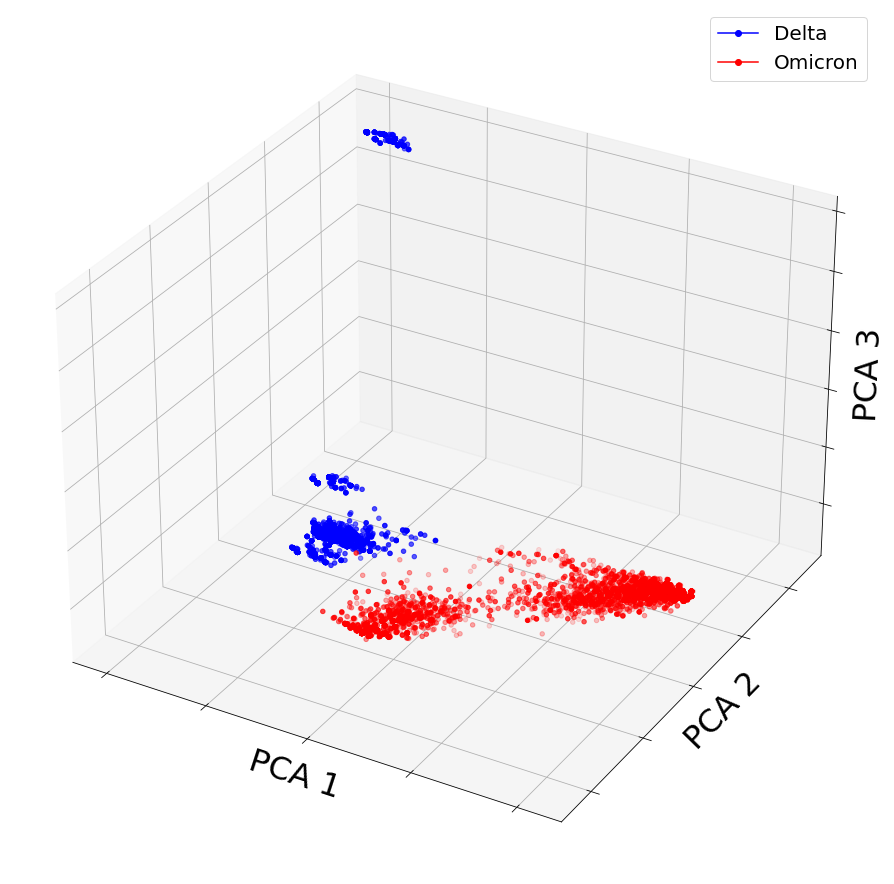

In [10]:
date_ints = np.array([ int(round(dt.timestamp())) for dt in meta1_partial['Collection date'].tolist()])
date_alpha = date_ints - min(date_ints)
date1_alpha = date_alpha / max(date_alpha)
date_ints = np.array([ int(round(dt.timestamp())) for dt in meta2_partial['Collection date'].tolist()])
date_alpha = date_ints - min(date_ints)
date2_alpha = date_alpha / max(date_alpha)
print(len(date1_alpha))
print(len(date2_alpha))


fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')


ax.scatter(s_pca[:n,0], s_pca[:n,1], s_pca[:n,2], c='b', label=variants[0], alpha=date1_alpha)
ax.scatter(s_pca[n:,0], s_pca[n:,1], s_pca[n:,2], c='r', label= variants[1], alpha=date2_alpha)
ax.set_xlabel('PCA 1', fontsize=32)
ax.set_ylabel('PCA 2', fontsize=32)
ax.set_zlabel('PCA 3', fontsize=32)

ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
ax.get_zaxis().set_ticklabels([])

var_labels = [ 'Delta', 'Omicron']
legend_elements = []
for i in range(len(var_labels)):
    legend_elements.append(Line2D([0], [0], color=['b','r'][i], marker='o', alpha=1, label=var_labels[i]))
ax.legend(handles=legend_elements, fontsize=20)

# legend = plt.legend(fontsize=28)
plt.savefig('spikeprot_variant_pca3D.pdf',transparent=True,dpi=300)

plt.show()


In [11]:

# number of positions
n_var = s0_full.shape[1]
n_seq = s0_full.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0_full[:,i])) for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
# print(\"(Sanity Check) Column indices of first and (\",i1i2[0],\") and last (\",i1i2[-1],\") positions\")
# print(\"(Sanity Check) Column indices of second and (\",i1i2[1],\") and second to last (\",i1i2[-2],\") positions\")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 344
Number of sequences: 20000
Number of different amino acids at each position [3 4 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 3 4 2 2 2 2 3 2 3 2 1 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 5 5 4 3 4 4 4 4 4 4 4 3 4 4 4 3 4 3 3 3 3 3
 3 2 4 3 2 4 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 4
 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 2 4 1 2 2 3 2 1 4 3 3 2
 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 2 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 2 1 2 2 1 3 1 2 3 3 2 3 1 2 2 2 1 1 2 3
 2 2 2 1 1 2 1 1 1 1 1]
Total number of variables 651


In [12]:
from joblib import Parallel, delayed                                                                     
import expectation_reflection as ER                                                                      

variant_w = {}
variant_b = {} 

# Expectation Reflection                                                                                 
#=========================================================================================#
def predict_w(s,i0,i1i2,niter_max,l2):                                                                   
    #print('i0:',i0)                                                                                     
    i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                        
    x = np.hstack([s[:,:i1],s[:,i2:]])                                                                   
    y = s[:,i1:i2]                                                                                       
    h01,w1 = ER.fit(x,y,niter_max,l2)                                                                    
    return h01,w1                                                                                        

print('s shape: ', s.shape)
for variant in variants:
    w_file = "%s_w_partial.npy" % variant        # partial because not using all sequences
    b_file = "%s_b_partial.npy" % variant        # partial because not using all sequences
        
    if os.path.exists(w_file):                                                          
        w_ER = np.load(w_file)       
        b = np.load(b_file) 
        print('w_ER shape: ', w_ER.shape)
        no_w = False
    else: 
        no_w = True
        
    # w_ER must be the same dimensions as s-onehot
    if no_w or w_ER.shape[1] != s.shape[1]:
        print('generating w_ER for %s' % variant)
        if variant == 'Omicron':
            s_train = s[:n]
        elif variant == 'Delta':
            s_train = s[n:]
        # Define wight matrix with variable for each possible amino acid at each sequence position               
        w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
        h0 = np.zeros(mx.sum())    
        #-------------------------------                                                                     
        # parallel                                                                                           
        start_time = timeit.default_timer()                                                                  
        res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
                (s_train,i0,i1i2,niter_max=10,l2=100.0)                                                          
                for i0 in range(n_var))                                                                      

        run_time = timeit.default_timer() - start_time                                                       
        print('run time:',run_time)                                                                          
        #------------------------------- 
        for i0 in range(n_var):
            i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    

            h01 = res[i0][0]                                                                                 
            w1 = res[i0][1]

            h0[i1:i2] = h01                                                                                  
            w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
            w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      

        # make w symmetric                                                                                   
        w_ER = (w_ER + w_ER.T)/2.                                                                            
        b = h0

        np.save(w_file, w_ER)
        np.save(b_file, b)
        
    variant_w[variant] = w_ER
    variant_b[variant] = b


s shape:  (20000, 651)
w_ER shape:  (651, 651)
w_ER shape:  (651, 651)


In [13]:
from scipy.spatial import distance
# Proplerly defined Energy.. 1/24/2023

def col_H(i, i1i2, w, b, s):
    for ii, (i1,i2) in enumerate(i1i2):
        if i in range(i1,i2):
            break
    
    H_i = 0
    for j in range(len(s)):
        if j in range(i1,i2):
            continue
        H_i +=  w[i,j] * s[j] 
    H_i += b[i]
    return H_i

def E_parallel(i1i2, s, w, b, s2=None):
    s_len = len(s)
    
    # Caluculate Hi for every column of H, includeing bias.
    resH = Parallel(n_jobs = 20-2)(delayed(col_H)                                                   
        (i0, i1i2, w, b, s)
        for i0 in range(s_len)) 
#     print(np.array(resH).shape)
    H_array = resH
#     print(s)
#     print(max([max(wl) for wl in w]), min([min(wl) for wl in w]))
#     print(max(b), min(b))
#     print(max(H_array), min(H_array))
#     print('Calculated H for sequence')

    coshH = 0
    for i, H_i in enumerate(H_array):
            coshH += np.log(2 * np.cosh(H_i))
#         coshH += np.log(np.exp(H_i) + np.exp(-H_i))
#     print(coshH)
#     coshH = np.sum(np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]))

    
    E_array = []
    if s2 is not None:
        sum_sigH = np.sum(np.array([sig_i * H_array[i] for i, sig_i in enumerate(s2) ]))
        E_array  = np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]) 
        - np.array([sig_i * H_array[i] for i, sig_i in enumerate(s2) ])
    else:
        sum_sigH = np.sum(np.array([sig_i * H_array[i] for i, sig_i in enumerate(s) ]))
        E_array  = np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]) 
        - np.array([sig_i * H_array[i] for i, sig_i in enumerate(s) ])

    E = coshH - sum_sigH

    return E, E_array
   
def energy_diff(i1i2, s1, s2, w, b, return_pos_array=False):
    e_diff = 0.
    s_len = len(s1)
    


    if s_len != len(s2):
        print('sequences not comparable!')
        sys.exit(24)
        
#     E1,E1_array = E_parallel(i1i2, s1, w, b)
#     E2,E2_array = E_parallel(i1i2, s2, w, b)
#     Ediff1, Ediff1_array = E_parallel(i1i2, s1, w, b, s2=s2)
#     Ediff2, Ediff2_array = E_parallel(i1i2, s2, w, b, s2=s1)
    
#     E_diff = E1 + E2 - Ediff1 - Ediff2
#     E_diff_array = E1_array + E2_array - Ediff1_array - Ediff2_array
    E_diff, E_diff_array = E_parallel(i1i2, s1, w, b, s2=s2)
    if return_pos_array:
        return E_diff, E_diff_array
    else:
        return E_diff
    
    
print('identity energy difference: ', energy_diff(i1i2,s[1,:], s[1,:], variant_w['Omicron'],
                                                  variant_b['Omicron'], return_pos_array=True))
print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s[1,:],s[2,:],variant_w['Omicron'],
                                                  variant_b['Omicron'], return_pos_array=True))

print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s[1:3,:], 'hamming')))
print(distance.squareform(distance.pdist([s[1,:],s[2,:]], 'hamming'))[0][1])
print(variant_w['Omicron'].shape)
print(s.shape)

identity energy difference:  (1329.1601282584782, array([4.50484805, 4.50054142, 4.38431262, 4.29881276, 4.2037003 ,
       4.50262137, 4.38473779, 4.38359897, 4.46284134, 4.476451  ,
       4.50164203, 4.50143258, 4.38206576, 3.29102257, 3.39719971,
       4.49188686, 4.47588702, 4.38521066, 4.49905298, 4.50946531,
       4.38116888, 4.50511137, 4.38330998, 4.52306441, 4.5032555 ,
       4.38316527, 4.47055091, 4.47379205, 4.50781084, 4.50185156,
       4.3838766 , 4.50125628, 4.5009514 , 4.38050905, 4.38567295,
       4.51690199, 4.53870128, 4.50136461, 4.50052014, 4.43794703,
       4.44402018, 4.5030144 , 4.50142786, 4.31692891, 4.3404409 ,
       4.51472193, 4.5083818 , 4.23170551, 4.34698167, 4.49947323,
       4.3806409 , 3.92820337, 4.51075016, 3.81809179, 4.16004335,
       4.15147318, 4.41276601, 4.41287454, 4.39538906, 4.40268625,
       4.50363603, 4.50302535, 4.50606314, 4.53971384, 4.37903612,
       4.38001346, 4.38874677, 4.50065766, 4.50451639, 4.40312833,
       3.830

seq 1 vs 2 energy difference:  (1553.5021522638008, array([4.50484805, 4.50054142, 4.38431262, 4.29881276, 4.2037003 ,
       4.50262137, 4.38473779, 4.38359897, 4.46284134, 4.476451  ,
       4.50164203, 4.50143258, 4.38206576, 3.29102257, 3.39719971,
       4.49188686, 4.47588702, 4.38521066, 4.49905298, 4.50946531,
       4.38116888, 4.50511137, 4.38330998, 4.52306441, 4.5032555 ,
       4.38316527, 4.47055091, 4.47379205, 4.50781084, 4.50185156,
       4.3838766 , 4.50125628, 4.5009514 , 4.38050905, 4.38567295,
       4.51690199, 4.53870128, 4.50136461, 4.50052014, 4.43794703,
       4.44402018, 4.5030144 , 4.50142786, 4.31692891, 4.3404409 ,
       4.51472193, 4.5083818 , 4.23170551, 4.34698167, 4.49947323,
       4.3806409 , 3.92820337, 4.51075016, 3.81809179, 4.16004335,
       4.15147318, 4.41276601, 4.41287454, 4.39538906, 4.40268625,
       4.50363603, 4.50302535, 4.50606314, 4.53971384, 4.37903612,
       4.38001346, 4.38874677, 4.50065766, 4.50451639, 4.40312833,
       3.8

In [14]:
print(variant_w.keys())
s_E_rows = []
for variant in variant_w.keys():
    w_var = variant_w[variant]
    b_var = variant_b[variant]
    if variant == 'Omicron':
        gp_mean = np.mean(s[:n], axis=0)
    elif variant == 'Delta':
        gp_mean = np.mean(s[n:], axis=0)
    if os.path.exists('%s_SvsAVG_energy.npy' % variant):
        print('loading %s energy landscape' % variant)
        s_E_row = np.load('%s_SvsAVG_energy.npy' % variant)
    else:
        s_E_row = np.zeros(len(s))
        res = Parallel(n_jobs = 20-2)(delayed(energy_diff)
                (i1i2,gp_mean,s[i0,:],w_var,b_var)
                for i0 in range(len(s)))
        s_E_row = np.array(res)
        np.save('%s_SvsAVG_energy.npy' % variant, s_E_row)
    s_E_rows.append(s_E_row)


dict_keys(['Delta', 'Omicron'])
loading Delta energy landscape
loading Omicron energy landscape


[array([1353.70221669, 1353.70221669, 1369.39647493, ..., 1299.10396644,
       1260.4557586 , 1357.14946124]), array([1273.77678636, 1273.77678636, 1279.81318043, ..., 1426.0253488 ,
       1470.6242498 , 1562.36976667])]
20000
x (20000,)
y (20000,)
x (20000,)
y (20000,)
x (20000,)
y (20000,)


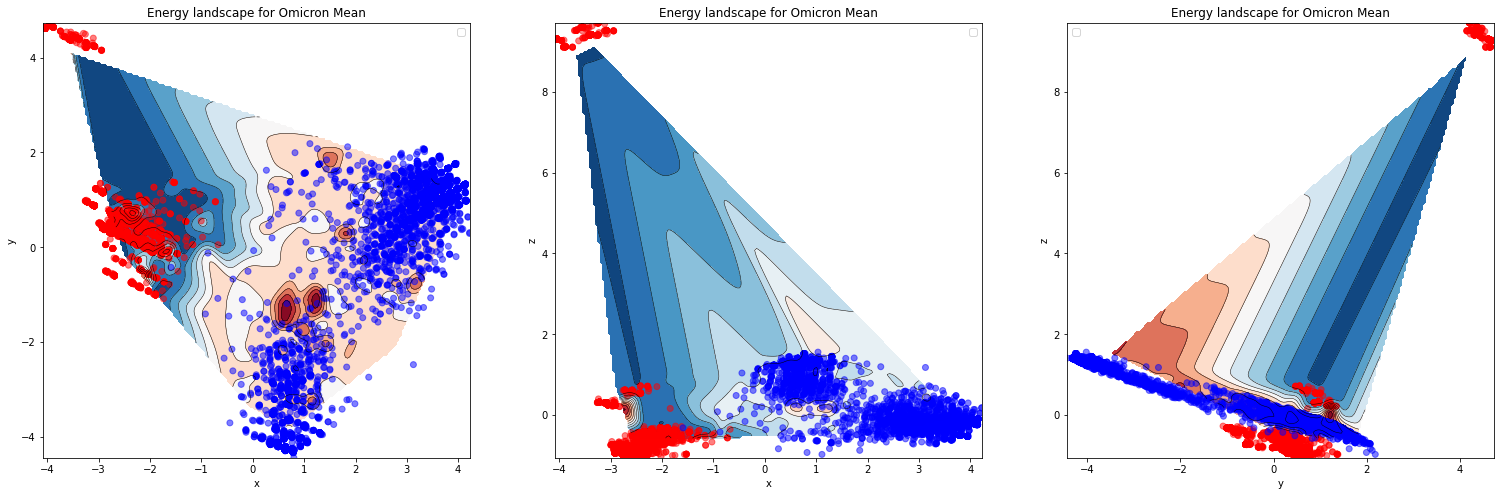

In [15]:
print(s_E_rows)


cluster_colors = []
for i in range(len(s)):
    if i <n:
        cluster_colors.append('r')
    else:
        cluster_colors.append('b')
legend_elements = [Line2D([0], [0], color=cluster_colors[i], marker='o', label=variants[i]) for i in range(len(variants))]

s0_len = len(s0_full)


fig1 = plt.figure(figsize=(26,8))

ax1  = fig1.add_subplot(131)    
ax2  = fig1.add_subplot(132)    
ax3  = fig1.add_subplot(133)    
    

msa_1 = 1
msa_2 =0

gp1_mean = np.mean(s[:n],axis=0)
gp2_mean = np.mean(s[n:],axis=0)


gp1_mean_pca = pca.transform([gp1_mean])[0]
gp2_mean_pca = pca.transform([gp2_mean])[0]

z = s_E_rows[msa_1]
print(len(s_E_rows[msa_1]))


planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
ax_labels = ['x', 'y' , 'z']
axes = [ax1, ax2, ax3]  # panel 1 to plot the different planes for msa 1

for dim in range(3):
    x = s_pca[:,planes[dim][0]]
    y = s_pca[:,planes[dim][1]]
    print('x', x.shape)
    print('y', y.shape)

    n_levels=10
    sigma = .001
    # Create grid values first.
    ngridx = 200
    ngridy = 200
    xi = np.linspace(min(x), max(x), ngridx)
    yi = np.linspace(min(y), max(y), ngridy)


    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(x, y)

    interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


    Xi, Yi = np.meshgrid(xi, yi)

    zi = interpolator(Xi, Yi)
    Zi = gaussian_filter(zi, sigma=2.)
  

    # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    axes[dim].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
    cntr11 = axes[dim].contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


    # plot the sequence points for both families
    axes[dim].scatter(s_pca[:,planes[dim][0]], s_pca[:,planes[dim][1]], color=cluster_colors,alpha=.5)  

    axes[dim].legend(handles=legend_elements[i:i+2])
    axes[dim].set_title('Energy landscape for %s Mean'% variants[msa_1])
    axes[dim].set_xlabel(ax_labels[planes[dim][0]])
    axes[dim].set_ylabel(ax_labels[planes[dim][1]])
        
        

In [16]:
# Spectral Clustering of OneHot representation of MSA
# https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c

from sklearn.cluster import SpectralClustering
n_cluster = 4
if os.path.exists("cov_spike_%dcluster_ODvars.pkl" % n_cluster):
    clustering = pickle.load( open("cov_spike_%dcluster_ODvars.pickle" % n_cluster, "rb"))
else:
    clustering = SpectralClustering(n_clusters=n_cluster, random_state=0).fit(s_pca)
    # save 4 clustered omicron and delta.
    pickle.dump(clustering, open("cov_spike_%dcluster_ODvars.pickle" % n_cluster, "wb"))


Exception ignored in: <_io.FileIO name='cov_spike_4cluster_ODvars.pickle' mode='wb' closefd=True>
Traceback (most recent call last):
  File "/tmp/ipykernel_103630/3975204781.py", line 11, in <module>


In [17]:

colors = ['r','b','g','y']
print(np.unique(clustering.labels_, return_counts=True))
print(clustering.labels_)
cluster_colors = [colors[i][0] for i in clustering.labels_]

c1_indx = [indx for i,indx in enumerate(range(len(s_pca))) if clustering.labels_[i] == 0]
c2_indx = [indx for i,indx in enumerate(range(len(s_pca))) if clustering.labels_[i] == 1]
c3_indx = [indx for i,indx in enumerate(range(len(s_pca))) if clustering.labels_[i] == 2]
c4_indx = [indx for i,indx in enumerate(range(len(s_pca))) if clustering.labels_[i] == 3]

(array([0, 1, 2, 3], dtype=int32), array([6574,  534, 3419, 9473]))
[3 3 3 ... 0 0 0]


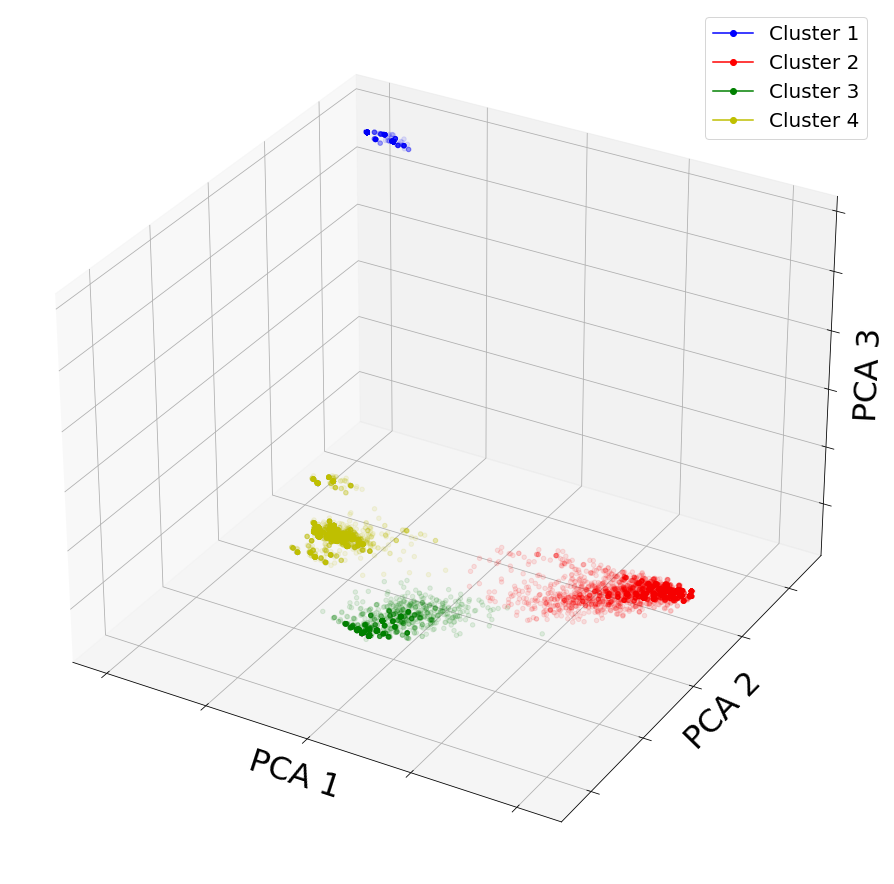

In [18]:
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')

ax.scatter(s_pca[c1_indx,0], s_pca[c1_indx,1], s_pca[c1_indx,2], c=colors[0], label='Cluster 1', alpha=.1)
ax.scatter(s_pca[c2_indx,0], s_pca[c2_indx,1], s_pca[c2_indx,2], c=colors[1], label='Cluster 2', alpha=.1)
ax.scatter(s_pca[c3_indx,0], s_pca[c3_indx,1], s_pca[c3_indx,2], c=colors[2], label='Cluster 3', alpha=.1)
ax.scatter(s_pca[c4_indx,0], s_pca[c4_indx,1], s_pca[c4_indx,2], c=colors[3], label='Cluster 4', alpha=.1)
ax.set_xlabel('PCA 1', fontsize=32)
ax.set_ylabel('PCA 2', fontsize=32)
ax.set_zlabel('PCA 3', fontsize=32)

ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
ax.get_zaxis().set_ticklabels([])


var_labels = [ 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
legend_elements = []
for i in range(len(var_labels)):
    legend_elements.append(Line2D([0], [0], color=['b','r','g','y'][i], marker='o', alpha=1, label=var_labels[i]))
ax.legend(handles=legend_elements, fontsize=20)
plt.savefig('spikeprot_cluster_pca3D.pdf',transparent=True,dpi=300)

plt.show()


20000
20000
            Accession ID             Type Clade Pango lineage  \
1612262  EPI_ISL_6847706  betacoronavirus    GK        AY.4.6   
442613   EPI_ISL_4893444  betacoronavirus    GK          AY.4   
1240274  EPI_ISL_3579017  betacoronavirus    GK         AY.43   
1375655  EPI_ISL_8112434  betacoronavirus    GK       AY.29.2   
1649615  EPI_ISL_6842222  betacoronavirus    GK         AY.85   

        Pangolin version                                   AA Substitutions  \
1612262     PLEARN-v1.16  (N_G215C,NSP3_A1711V,Spike_T95I,N_D63G,N_R203M...   
442613      PLEARN-v1.16  (N_G215C,NSP3_A1711V,N_D63G,N_R203M,NSP12_G671...   
1240274     PLEARN-v1.16  (N_G215C,N_D63G,N_R203M,NSP12_G671S,Spike_G142...   
1375655      PANGO-v1.16  (N_G215C,Spike_T95I,N_D63G,N_R203M,NSP12_G671S...   
1649615     PLEARN-v1.16  (N_G215C,Spike_T95I,N_D63G,N_R203M,NSP12_G671S...   

                                                   Variant Collection date  \
1612262  VOC Delta GK (B.1.617.2+AY.*) first

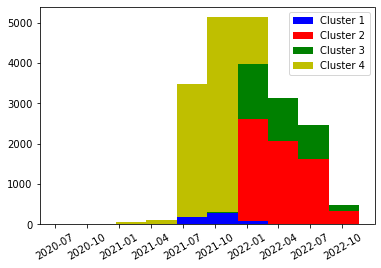

In [19]:
print(len(c1_indx) + len(c2_indx) + len(c3_indx) + len(c4_indx))
print(len(df))

# get sample df
meta1_partial = meta1.iloc[var1_partial_index].copy()
meta2_partial = meta2.iloc[var2_partial_index].copy()
print(meta1_partial.head())
# print(meta2_partial.head())

# print(len(meta1_partial))
# extract dates for variant samples


meta1_partial["Collection date"] = meta1_partial["Collection date"].astype("datetime64")
meta2_partial["Collection date"] = meta2_partial["Collection date"].astype("datetime64")

df = pd.concat([meta1_partial, meta2_partial])[['Collection date', 'Variant']]
df['Cluster'] = clustering.labels_
df1 = meta1_partial[['Collection date', 'Variant']]
df2 = meta2_partial[['Collection date', 'Variant']]

print(df['Cluster'])

fig, ax = plt.subplots(nrows=1, ncols=1)


# get Delta indices in metadataframe
x1 = list(df[df['Cluster'] == 0]['Collection date'])
x2 = list(df[df['Cluster'] == 1]['Collection date'])
x3 = list(df[df['Cluster'] == 2]['Collection date'])
x4 = list(df[df['Cluster'] == 3]['Collection date'])
print(len(x1), len(x2), len(x3), len(x4))

plt.hist([x2,x1,x3,x4], label=var_labels, color=['b','r','g','y'], stacked=True)
plt.xticks(rotation=30)
# Set the legend and labels
#
plt.legend()

In [20]:
# generate w for cluster 1 (red cluster)
clusters = ['c1o4', 'c2o4', 'c3o4', 'c4o4']
cluster_indx = [c1_indx, c2_indx, c3_indx, c4_indx]
cluster_w = {}
cluster_b = {}
for i, cluster in enumerate(clusters):
    print('Generating w and b for cluster %s' % cluster)
    w_file = "%s_w_partial.npy" % cluster        # partial because not using all sequences
    b_file = "%s_b_partial.npy" % cluster        # partial because not using all sequences

    if os.path.exists(w_file):                                                          
        w_ER = np.load(w_file)       
        b = np.load(b_file)                                                                               

    else:  
        s_train = s[cluster_indx[i]]
        # Define wight matrix with variable for each possible amino acid at each sequence position               
        w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
        h0 = np.zeros(mx.sum())    
        #-------------------------------                                                                     
        # parallel                                                                                           
        start_time = timeit.default_timer()                                                                  
        res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
                (s_train,i0,i1i2,niter_max=10,l2=100.0)                                                          
                for i0 in range(n_var))                                                                      

        run_time = timeit.default_timer() - start_time                                                       
        print('run time:',run_time)                                                                          
        #------------------------------- 
        for i0 in range(n_var):
            i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    

            h01 = res[i0][0]                                                                                 
            w1 = res[i0][1]

            h0[i1:i2] = h01                                                                                  
            w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
            w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      

        # make w symmetric                                                                                   
        w_ER = (w_ER + w_ER.T)/2.                                                                            
        b = h0

        np.save(w_file, w_ER)
        np.save(b_file, b)

    cluster_w[cluster] = w_ER
    cluster_b[cluster] = b


Generating w and b for cluster c1o4
Generating w and b for cluster c2o4
Generating w and b for cluster c3o4
Generating w and b for cluster c4o4


In [21]:
# generate energy landscape for clusters
cluster_E_rows = []
for i, cluster in enumerate(clusters[:1]):
    print('Generating E-diff from cluster mean for cluster %s' % cluster)
    w_var = cluster_w[cluster]
    b_var = cluster_b[cluster]

    gp_mean = np.mean(s[cluster_indx[i]], axis=0)
    if os.path.exists('%s_SvsAVG_energy.npy' % cluster):
        print('loading %s energy landscape' % cluster)
        s_E_row = np.load('%s_SvsAVG_energy.npy' % cluster)
    else:
        s_E_row = np.zeros(len(s))
        res = Parallel(n_jobs = 20-2)(delayed(energy_diff)
                (i1i2,gp_mean,s[i0,:],w_var,b_var)
                for i0 in range(len(s)))
        s_E_row = np.array(res)
        np.save('%s_SvsAVG_energy.npy' % cluster, s_E_row)
    cluster_E_rows.append(s_E_row)

Generating E-diff from cluster mean for cluster c1o4
loading c1o4 energy landscape


20000
x (20000,)
y (20000,)
x (20000,)
y (20000,)
x (20000,)
y (20000,)


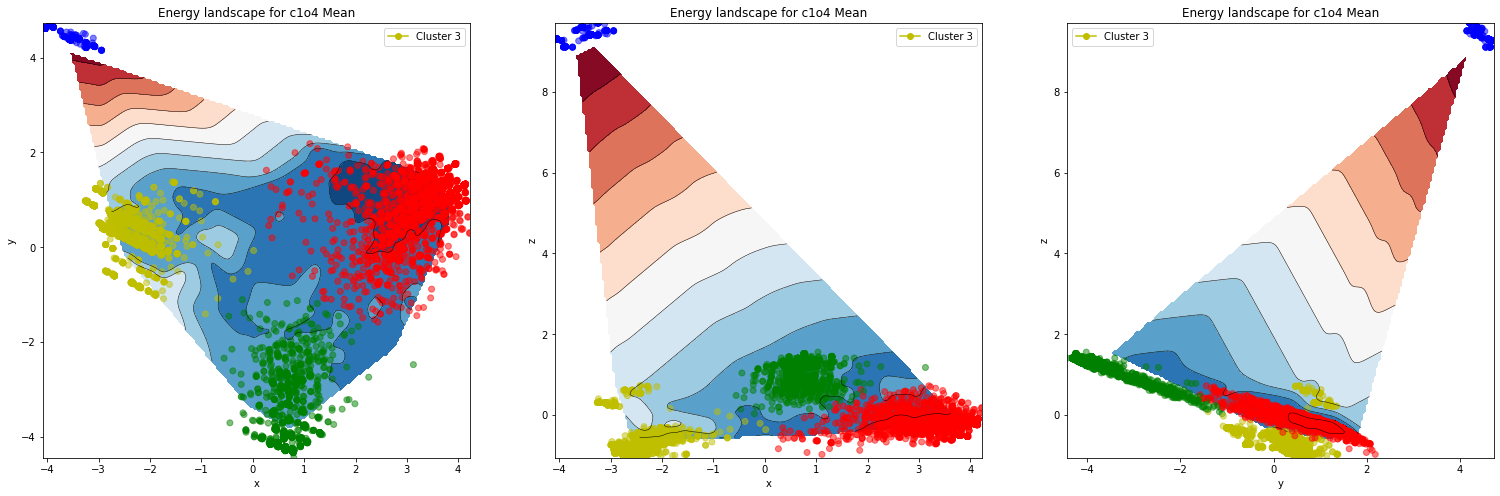

In [22]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.tri as tri
from matplotlib.lines import Line2D

 
legend_elements = []
for i in range(n_cluster):
    legend_elements.append(Line2D([0], [0], color=colors[i], marker='o', label='Cluster %d' % i))

s0_len = len(s0_full)


fig1 = plt.figure(figsize=(26,8))

ax1  = fig1.add_subplot(131)    
ax2  = fig1.add_subplot(132)    
ax3  = fig1.add_subplot(133)    
    

msa_1 = 0
msa_2 =msa_1+1


z = cluster_E_rows[msa_1]
print(len(cluster_E_rows[msa_1]))


planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
ax_labels = ['x', 'y' , 'z']
axes = [ax1, ax2, ax3]  # panel 1 to plot the different planes for msa 1

for dim in range(3):
    x = s_pca[:,planes[dim][0]]
    y = s_pca[:,planes[dim][1]]
    print('x', x.shape)
    print('y', y.shape)

    n_levels=10
    sigma = .001
    # Create grid values first.
    ngridx = 200
    ngridy = 200
    xi = np.linspace(min(x), max(x), ngridx)
    yi = np.linspace(min(y), max(y), ngridy)


    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(x, y)

    interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


    Xi, Yi = np.meshgrid(xi, yi)

    zi = interpolator(Xi, Yi)
    Zi = gaussian_filter(zi, sigma=2.)
  

    # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    axes[dim].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
    cntr11 = axes[dim].contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


    # plot the sequence points for both families
    axes[dim].scatter(s_pca[:,planes[dim][0]], s_pca[:,planes[dim][1]], c=cluster_colors,alpha=.5)  

    axes[dim].legend(handles=legend_elements[i:i+2])
    axes[dim].set_title('Energy landscape for %s Mean'% clusters[msa_1])
    axes[dim].set_xlabel(ax_labels[planes[dim][0]])
    axes[dim].set_ylabel(ax_labels[planes[dim][1]])
       

In [23]:
# get cluster 1/4 boundary sequences

from sklearn import svm
gp1 = s_pca[cluster_indx[0],:3]
gp3 = s_pca[cluster_indx[2],:3]
gp4 = s_pca[cluster_indx[3],:3]
gp1_mean = np.mean(gp1, axis=0)
gp3_mean = np.mean(gp3, axis=0)
gp4_mean = np.mean(gp4, axis=0)

gp14 = np.append(gp1, gp4, axis=0)
clf_14 = svm.SVC(kernel='linear')
y14 = np.zeros(len(gp14))
y14[:len(gp1)] = 1
clf_14.fit(gp14,y14)
    
gp13 = np.append(gp1, gp3, axis=0)
clf_13 = svm.SVC(kernel='linear')
y13 = np.zeros(len(gp13))
y13[:len(gp1)] = 1
clf_13.fit(gp13,y13)

def perp_dist(x1, y1, z1, a, b, c, d):
    d = abs((a * x1 + b * y1 + c * z1 + d))
    e = (math.sqrt(a * a + b * b + c * c))
    return d/e

c1_indx = cluster_indx[0]
import math
min_dist = 100.
print(len(c1_indx))
for i, pt in enumerate(gp1):
    pt_dist = perp_dist(pt[0],pt[1],pt[2], clf_13.coef_[0][0],clf_13.coef_[0][1],clf_13.coef_[0][2],clf_13.intercept_[0])
    if pt_dist < min_dist:
        min_dist = pt_dist
        min_id = c1_indx[i]
print(min_dist)
print(min_id)
min_id_13 = min_id

min_dist = 100.
print(len(c1_indx))
for i, pt in enumerate(gp1):
    pt_dist = perp_dist(pt[0],pt[1],pt[2], clf_14.coef_[0][0],clf_14.coef_[0][1],clf_14.coef_[0][2],clf_14.intercept_[0])
    if pt_dist < min_dist:
        min_dist = pt_dist
        min_id = c1_indx[i]
print(min_dist)
print(min_id)
min_id_14 = min_id                   


6574
0.13563921406285834
18563
6574
0.34622093353073335
14205


In [24]:
# get probability of all single mutations for a given sequence and w/b.
def prob_mut(seq, i1i2, w, b):
    
    # Caluculate Hi for every column of H, includeing bias.
    resH = Parallel(n_jobs = 20-2)(delayed(col_H)                                                   
        (i0, i1i2, w, b, seq)
        for i0 in range(len(seq))) 
    H_array = resH


    count = 0
    prob_tot = 0.
    max_prob = 0.
    max_id = -1
    for i0 in range(n_var):
        i1,i2 = i1i2[i0][0], i1i2[i0][1]

        #We dont need to go section/position by section/position but this is more explicit
        for ii,i in enumerate(range(i1,i2)):
            H_i = H_array[i]
            temp_sequence = np.copy(seq)
            sig_section = np.zeros(i2-i1)
            
            sig_section[ii] = 1.
            temp_sequence[i1:i2] = sig_section
            count+=1
            
            mut_probs = np.array([np.exp(sig_j * H_array[j]) / (2 * np.cosh(H_array[j])) for j, sig_j in enumerate(seq)])
            mut_prob =  np.exp( H_i) / (2 * np.cosh(H_i))
            
            prob_tot += np.sum(mut_prob)
    return prob_tot

def prob_mut1(seq, i1i2, w, b, ncpu=2):
    
    # Caluculate Hi for every column of H, includeing bias.
    resH = Parallel(n_jobs = ncpu)(delayed(col_H)                                                   
        (i0, i1i2, w, b, seq)
        for i0 in range(len(seq))) 
    H_array = resH

    mut_probs = []
    prob_tot = 0.
    for i in range(len(seq)):
        H_i = H_array[i]
        mut_prob =  np.exp( H_i) / (2 * np.cosh(H_i))
        prob_tot += mut_prob
        mut_probs.append(mut_prob)
        
    return prob_tot, np.array(mut_probs)

boundary_seq_13 = s[min_id_13]
print(len(cluster_b['c1o4']))
prob_gp1 = prob_mut(boundary_seq_13, i1i2, cluster_w['c1o4'], cluster_b['c1o4'])
prob_gp2 = prob_mut(boundary_seq_13, i1i2, cluster_w['c3o4'], cluster_b['c3o4'])
prob1_gp1, prob_array_gp1 = prob_mut1(boundary_seq_13, i1i2, cluster_w['c1o4'], cluster_b['c1o4'])
prob1_gp2, prob_array_gp2 = prob_mut1(boundary_seq_13, i1i2, cluster_w['c3o4'], cluster_b['c3o4'])
print(prob_gp1, prob_gp2)
print(prob1_gp1, prob1_gp2)
print(max(prob_array_gp1), min(prob_array_gp1))
print(max(prob_array_gp2), min(prob_array_gp2))

boundary_seq_14 = s[min_id_14]
print(len(cluster_b['c1o4']))
prob_gp1 = prob_mut(boundary_seq_14, i1i2, cluster_w['c1o4'], cluster_b['c1o4'])
prob_gp2 = prob_mut(boundary_seq_14, i1i2, cluster_w['c4o4'], cluster_b['c4o4'])
prob1_gp1, prob_array_gp1 = prob_mut1(boundary_seq_14, i1i2, cluster_w['c1o4'], cluster_b['c1o4'])
prob1_gp2, prob_array_gp2 = prob_mut1(boundary_seq_14, i1i2, cluster_w['c4o4'], cluster_b['c4o4'])
print(prob_gp1, prob_gp2)
print(prob1_gp1, prob1_gp2)
print(max(prob_array_gp1), min(prob_array_gp1))
print(max(prob_array_gp2), min(prob_array_gp2))




651
343.8005589730782 343.72938417556304
343.8005589730782 343.72938417556304
0.9999028148574118 8.42353037071474e-05
0.9999043694066507 9.696518387119171e-05
651
344.0221114481515 343.61736530317734
344.0221114481515 343.61736530317734
0.9998723993614347 1.1725623140649861e-05
0.999963617161814 1.1813547480729804e-05


In [25]:
# Choose single mutation given sequence and w/b.

def w_seq_walk(seq, i1i2, w_in, b_in, n_iter=1000,seed=42,ncpu=2):
    random.seed(seed)
    
    if w_in.ndim > 2:
        if w_in.ndim-1 != b_in.ndim or w_in[0].shape[1] != b_in[0].shape[0]:
            sys.exit(42)
        print('alternating walk between %d w/bs' % len(w_in))
        directions = []

    else:
        print('random walk using a cluster\'s w/b')
        w = w_in
        b = b_in
         
    seq_walk = [seq]
    n_var = len(i1i2)
    for itr in range(n_iter):
        if w_in.ndim > 2:
            indx = np.random.choice(range(len(w_in)))
            w = w_in[indx]
            b = b_in[indx]
            directions.append(indx)
        # Randomly choose seqwuence mutation (weighted with current sequence and w/b)
        prob_gp1, prob_array_gp1 = prob_mut1(seq_walk[-1], i1i2, w, b, ncpu=ncpu)
        mut_pos_aa = np.random.choice(range(len(prob_array_gp1)), p=prob_array_gp1/np.sum(prob_array_gp1))
        # print([(aa,j) for aa,j in enumerate(seq_walk[-1])])
        
        # find position mut_pos_aa is in
        found = False
        for i0 in range(n_var):
            i1,i2 = i1i2[i0][0], i1i2[i0][1]
            for i, ii0 in enumerate(range(i1,i2)):
                if mut_pos_aa == ii0:
                    found = True
                    break
            if found:
                break
        # print('%d (%d, %d) in ' % (mut_pos_aa, i, ii0), i1i2[i0])
        
        # apply mutation
        temp_sequence = np.copy(seq_walk[-1])
        sig_section = np.zeros(i2-i1)
        sig_section[i] = 1.
        temp_sequence[i1:i2] = sig_section
        # print([(aa,j) for aa,j in enumerate(temp_sequence)])
        # print('\n\n')
        seq_walk.append(temp_sequence)
    if w_in.ndim > 2:
        return seq_walk, directions
    else:
        return seq_walk

In [26]:
# sanity check on small subset -- make sure to uncomment all the print statements
if 0:
    positions_to_delete = [i for i in range(len(cluster_w['c1o4'])) if i >= i1i2[4][1]]
    w_test = np.delete(cluster_w['c1o4'], positions_to_delete, axis=0)
    w_test = np.delete(w_test, positions_to_delete, axis=1)

    b_test = np.delete(cluster_b['c1o4'], positions_to_delete)
    seq_test = boundary_seq[:i1i2[4+1][0]]
    print(len(positions_to_delete))
    print(len(boundary_seq))
    print(len(seq_test))
    print(w_test.shape)
    print(w_test)
    print(b_test.shape)
    print(b_test)
    print(seq_test.shape)
    print(seq_test, '\n\n\n')

    i1i2_test = i1i2[:4+1]
    print(i1i2_test)
    test_sequence_walk = w_seq_walk(seq_test, i1i2_test, w_test, b_test, n_iter = 10)

print(boundary_seq_14.shape)


    
w_group = np.array([cluster_w['c1o4'], cluster_w['c4o4']])
b_group = np.array([cluster_b['c1o4'],cluster_b['c4o4']])

boundary_sequence_walk, directions = w_seq_walk(boundary_seq_14, i1i2, w_group, b_group, n_iter = 10)
print(directions)
boundary_sequence_walk = w_seq_walk(boundary_seq_14, i1i2, cluster_w['c1o4'], cluster_b['c1o4'], n_iter = 10)



(651,)
alternating walk between 2 w/bs
[1, 1, 1, 0, 0, 0, 0, 0, 1, 0]
random walk using a cluster's w/b


[[ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]
 [ 0.3749188   0.19777803 -0.42824678]]
20000
x (20000,)
y (20000,)


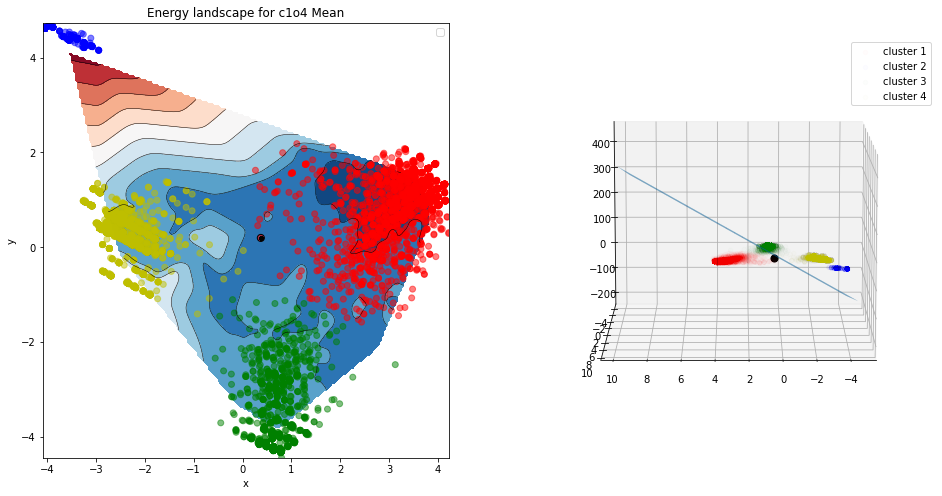

In [27]:
BS_pca = pca.transform([boundary_seq_14])[0]
BSW_pca = pca.transform(boundary_sequence_walk)
print(BSW_pca)

fig1 = plt.figure(figsize=(16,8))
ax1  = fig1.add_subplot(121)    
ax2  = fig1.add_subplot(122, projection='3d')

msa_1 = 0
msa_2 =msa_1+1

z = cluster_E_rows[msa_1]
print(len(cluster_E_rows[msa_1]))


planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
ax_labels = ['x', 'y' , 'z']
axes = [ax1, ax2]  # panel 1 to plot the different planes for msa 1

x = s_pca[:,planes[0][0]]
y = s_pca[:,planes[0][1]]
print('x', x.shape)
print('y', y.shape)

n_levels=10
sigma = .001
# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x), max(x), ngridx)
yi = np.linspace(min(y), max(y), ngridy)


# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)

interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


Xi, Yi = np.meshgrid(xi, yi)

zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)


# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
axes[0].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr11 = axes[0].contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


# plot the sequence points for both families
axes[0].scatter(s_pca[:,planes[0][0]], s_pca[:,planes[0][1]], c=cluster_colors,alpha=.5)  
axes[0].plot(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], c='k', )
axes[0].scatter(BS_pca[planes[0][0]], BS_pca[planes[0][1]], facecolors='none', edgecolors='k',s=50 )
axes[0].scatter(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], c='k',s=10 )

axes[0].legend(handles=legend_elements[i:i+2])
axes[0].set_title('Energy landscape for %s Mean'% clusters[msa_1])
axes[0].set_xlabel(ax_labels[planes[0][0]])
axes[0].set_ylabel(ax_labels[planes[0][1]])


# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
decision_boundary = lambda x,y: (-clf_14.intercept_[0]-clf_14.coef_[0][0]*x -clf_14.coef_[0][1]*y) / clf_14.coef_[0][2]

tmp = np.linspace(min(min(s_pca[:,0]),min(s_pca[:,1]),min(s_pca[:,2])),max(max(s_pca[:,0]),max(s_pca[:,1]),max(s_pca[:,2])),30)
xd,yd = np.meshgrid(tmp,tmp)


axes[1].scatter(s_pca[c1_indx,0], s_pca[c1_indx,1], s_pca[c1_indx,2], c=colors[0], label='cluster 1', alpha=.01)
axes[1].scatter(s_pca[c2_indx,0], s_pca[c2_indx,1], s_pca[c2_indx,2], c=colors[1], label='cluster 2', alpha=.01)
axes[1].scatter(s_pca[c3_indx,0], s_pca[c3_indx,1], s_pca[c3_indx,2], c=colors[2], label='cluster 3', alpha=.01)
axes[1].scatter(s_pca[c4_indx,0], s_pca[c4_indx,1], s_pca[c4_indx,2], c=colors[3], label='cluster 4', alpha=.01)

axes[1].plot_surface(xd, yd, decision_boundary(xd,yd),alpha=.7)
axes[1].scatter(BS_pca[0], BS_pca[1], BS_pca[2], c='k', s=50)

axes[1].view_init(10,90)
plt.legend()
plt.show()

In [ ]:
fig1 = plt.figure(figsize=(16,16))
ax1  = fig1.add_subplot(111)  


# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
# ax1.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr11 = ax1.contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


# plot the sequence points for both families
ax1.scatter(s_pca[:,planes[0][0]], s_pca[:,planes[0][1]], c=cluster_colors,alpha=.5)  

ax1.legend(handles=legend_elements[i:i+2])
ax1.set_xlabel(ax_labels[planes[0][0]])
ax1.set_ylabel(ax_labels[planes[0][1]])
ax1.set_xlabel('PCA 1', fontsize=32)
ax1.set_ylabel('PCA 2', fontsize=32)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
plt.savefig('spikeprot_cluster_energy.pdf',transparent=True,dpi=300)
plt.show()

In [ ]:
fig1 = plt.figure(figsize=(16,16))
ax1  = fig1.add_subplot(111)  


# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
# ax1.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr11 = ax1.contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


# plot the sequence points for both families
ax1.scatter(s_pca[:,planes[0][0]], s_pca[:,planes[0][1]], c=cluster_colors,alpha=.5)  
ax1.scatter(BS_pca[planes[0][0]], BS_pca[planes[0][1]], facecolors='none', edgecolors='k',s=200 )

ax1.legend(handles=legend_elements[i:i+2])
ax1.set_xlabel(ax_labels[planes[0][0]])
ax1.set_ylabel(ax_labels[planes[0][1]])
ax1.set_xlabel('PCA 1', fontsize=32)
ax1.set_ylabel('PCA 2', fontsize=32)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
plt.savefig('spikeprot_cluster_energy_BS.pdf',transparent=True,dpi=300)
plt.show()

In [ ]:
# parallel
print(cluster_w['c1o4'].shape)
print(cluster_b['c1o4'].shape)

print('Random Walk from boundary of cluster 1 and 4 with Cluster 1 w/b')
if 1:
    start_time = timeit.default_timer()                                                                  
    res1 = Parallel(n_jobs = 10)(delayed( w_seq_walk)                                                   
            (boundary_seq_14, i1i2, cluster_w['c1o4'], cluster_b['c1o4'], n_iter = 500,seed=i0, ncpu = 2)                                                          
            for i0 in range(20))                                                                      

    run_time = timeit.default_timer() - start_time    
    print('run time:',run_time) 
    np.save('20BSW_500i_c1o4.npy', res1)
else:
    res1 = np.load('20BSW_500i_c1o4.npy')
    res1 = np.load('50BSW_1000i_c14_w1.npy') # same sim just larger

    
print('Random Walk from boundary of cluster 1 and 4 with Cluster 4 w/b')
if 1:
    start_time = timeit.default_timer()                                                                  
    res2 = Parallel(n_jobs = 20)(delayed( w_seq_walk)                                                   
            (boundary_seq_14, i1i2, cluster_w['c4o4'], cluster_b['c4o4'], n_iter = 500,seed=i0, ncpu = 2)                                                          
            for i0 in range(20))  
    
    run_time = timeit.default_timer() - start_time    
    print('run time:',run_time) 
    np.save('20BSW_500i_c4o4.npy', res2)
else:
    res2 = np.load('20BSW_500i_c4o4.npy')
    res2 = np.load('50BSW_1000i_c14_w4.npy') # same sim just larger


    
print('Random Walk from boundary of cluster 1 and 3 with Cluster 3 w/b')
if 1:
    start_time = timeit.default_timer()                                                                  
    res3 = Parallel(n_jobs = 20)(delayed( w_seq_walk)                                                   
            (boundary_seq_14, i1i2, cluster_w['c3o4'], cluster_b['c3o4'], n_iter = 500,seed=i0, ncpu = 2)                                                          
            for i0 in range(20)) 


    run_time = timeit.default_timer() - start_time    
    print('run time:',run_time) 
    np.save('20BSW_500i_c3o4.npy', res3)
else:
    res3 = np.load('20BSW_500i_c3o4.npy')
    res3 = np.load('50BSW_1000i_c13_w3.npy') # same sim just larger

    

In [ ]:
BS_pca = pca.transform([boundary_seq_14])[0]
print(BSW_pca)

fig1 = plt.figure(figsize=(16,16))
ax1  = fig1.add_subplot(111)    

msa_1 = 0
msa_2 =msa_1+1

z = cluster_E_rows[msa_1]
print(len(cluster_E_rows[msa_1]))


planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
ax_labels = ['x', 'y' , 'z']
axes = [ax1]  # panel 1 to plot the different planes for msa 1

x = s_pca[:,planes[0][0]]
y = s_pca[:,planes[0][1]]
print('x', x.shape)
print('y', y.shape)

n_levels=10
sigma = .001
# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x), max(x), ngridx)
yi = np.linspace(min(y), max(y), ngridy)


# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)

interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


Xi, Yi = np.meshgrid(xi, yi)

zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)


# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
# axes[0].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr11 = axes[0].contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


# plot the sequence points for both families
axes[0].scatter(s_pca[:,planes[0][0]], s_pca[:,planes[0][1]], c=cluster_colors,alpha=.5)  
for walk in res1:
    BSW_pca = pca.transform(walk)

    axes[0].plot(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], c='r', lw=1 )
    axes[0].scatter(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], edgecolors='r', facecolors='r',alpha=.1, s=5 )
    axes[0].scatter(BSW_pca[-1,planes[0][0]], BSW_pca[-1,planes[0][1]], edgecolors='k', facecolors='r', s=50 )
axes[0].scatter(BS_pca[planes[0][0]], BS_pca[planes[0][1]], facecolors='k', edgecolors='k',s=50 )
for walk in res2:
    BSW_pca = pca.transform(walk)

    axes[0].plot(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], c='y', lw=1 )
    axes[0].scatter(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], edgecolors='y', facecolors='y',alpha=.1, s=5 )
    axes[0].scatter(BSW_pca[-1,planes[0][0]], BSW_pca[-1,planes[0][1]], edgecolors='k', facecolors='y', s=50 )
axes[0].scatter(BS_pca[planes[0][0]], BS_pca[planes[0][1]], facecolors='k', edgecolors='k',s=50 )
for walk in res3:
    BSW_pca = pca.transform(walk)

    axes[0].plot(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], c='g', lw=1 )
    axes[0].scatter(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], edgecolors='g', facecolors='g',alpha=.1, s=5 )
    axes[0].scatter(BSW_pca[-1,planes[0][0]], BSW_pca[-1,planes[0][1]], edgecolors='k', facecolors='g', s=50 )
axes[0].scatter(BS_pca[planes[0][0]], BS_pca[planes[0][1]], facecolors='k', edgecolors='k',s=50 )
axes[0].legend(handles=legend_elements[i:i+2])
# axes[0].set_title('Energy landscape for %s Mean'% clusters[msa_1])
axes[0].set_xlabel('PCA 1',fontsize=32)
axes[0].set_ylabel('PCA 2', fontsize=32)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
plt.savefig('spikeprot_cluster_mutation.pdf',transparent=True,dpi=300)


In [ ]:
print('Random Walk from boundary of cluster 1 and 4 with Cluster 1and4 w/b')
nwalk = 250

if 0:
    w_group = np.array([cluster_w['c1o4'], cluster_w['c4o4']])
    b_group = np.array([cluster_b['c1o4'], cluster_b['c4o4']])
    start_time = timeit.default_timer()                                                                  
    res14 = Parallel(n_jobs = 50)(delayed( w_seq_walk)                                                   
            (boundary_seq_13, i1i2, w_group, b_group, n_iter = 1000,seed=i0, ncpu = 2)                                                          
            for i0 in range(50)) 


    run_time = timeit.default_timer() - start_time    
    print('run time:',run_time) 
    BSW = []
    directions = []
    for walk, direction in res14:
        direction.append(direction)
        BSW.append(walk)
    np.save('50BSW_1000i_c14_w14.npy', BSW)
    np.save('50BSW_dir_1000i_c14_w14.npy', directions)


else:  
    BSW_14 = np.load('50BSW_1000i_c14_w14.npy')
    directions_14 = np.load('50BSW_dir_1000i_c14_w14.npy')

print('Random Walk from boundary of cluster 1 and 4 with Cluster 3and4 w/b')
if 1:
    w_group = np.array([cluster_w['c3o4'], cluster_w['c4o4']])
    b_group = np.array([cluster_b['c3o4'], cluster_b['c4o4']])
    start_time = timeit.default_timer()                                                                  
    res34 = Parallel(n_jobs = 50)(delayed( w_seq_walk)                                                   
            (boundary_seq_14, i1i2, w_group, b_group, n_iter = 1000,seed=i0, ncpu = 2)                                                          
            for i0 in range(nwalk)) 


    run_time = timeit.default_timer() - start_time    
    print('run time:',run_time) 
    BSW = []
    directions = []
    for walk, direction in res34:
        direction.append(direction)
        BSW.append(walk)
    np.save('%dBSW_1000i_c14_w34.npy' % nwalk, BSW)
    np.save('%dBSW_dir_1000i_c14_w34.npy' % nwalk , directions)
else:

    BSW_34 = np.load('%dBSW_1000i_c14_w34.npy'%nwalk)
    directions_34 = np.load('%dBSW_dir_1000i_c14_w34.npy'%nwalk)

In [ ]:


BS_pca = pca.transform([boundary_seq_14])[0]
print(BSW_pca)

fig1 = plt.figure(figsize=(16,16))
ax1  = fig1.add_subplot(111)    

msa_1 = 0
msa_2 =msa_1+1

z = cluster_E_rows[msa_1]
print(len(cluster_E_rows[msa_1]))


planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
ax_labels = ['x', 'y' , 'z']
axes = [ax1]  # panel 1 to plot the different planes for msa 1

x = s_pca[:,planes[0][0]]
y = s_pca[:,planes[0][1]]
print('x', x.shape)
print('y', y.shape)

n_levels=10
sigma = .001
# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x), max(x), ngridx)
yi = np.linspace(min(y), max(y), ngridy)


# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)

interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


Xi, Yi = np.meshgrid(xi, yi)

zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)


# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
axes[0].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr11 = axes[0].contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


# plot the sequence points for both families
axes[0].scatter(s_pca[:,planes[0][0]], s_pca[:,planes[0][1]], c=cluster_colors,alpha=.5)  
for walk in BSW_34:
    BSW_pca = pca.transform(walk)

    axes[0].plot(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], c='k', lw=1 )
    axes[0].scatter(BSW_pca[:,planes[0][0]], BSW_pca[:,planes[0][1]], edgecolors='k', facecolors='k',alpha=.1, s=5 )
    axes[0].scatter(BSW_pca[-1,planes[0][0]], BSW_pca[-1,planes[0][1]], edgecolors='k', facecolors='k', s=50 )
axes[0].scatter(BS_pca[planes[0][0]], BS_pca[planes[0][1]], facecolors='r', edgecolors='k',s=150 )

axes[0].legend(handles=legend_elements[i:i+2])
axes[0].set_title('Energy landscape for %s Mean'% clusters[msa_1])
axes[0].set_xlabel(ax_labels[planes[0][0]])
axes[0].set_ylabel(ax_labels[planes[0][1]])
